<a href="https://colab.research.google.com/github/musicjae/NLP/blob/master/seq2seq/seq2seq_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

KeyboardInterrupt: ignored

In [32]:
from IPython.display import Image


- source text: 번역의 원본이 되는 언어의 텍스트  
- target text: 번역되는 언어의 텍스트

# 1. Preprocessing  
  
- Take raw text file.  
- Split it into (1) train set, (2) test set.  
- Set hidden states of each encoder, decoder.  
- Bring model object of Encoder, Decoder  
- Train the model  
> It contains codes that the output of the Encoder is transferred into the Decoder as the input that it is hidden state vectors.
- Test it in evaluate fn

In [124]:
import random
import torch
import torch.nn as nn
import torch.optim as optim

 ["I want to study computer science.   나는 컴퓨터 과학을 공부하고 싶다.",
       "Writing codes is interesting but difficult. 코드를 작성하는 것은 재밌지만 어렵다.",
       "Studying the Natural Language Processing requires excellent coding skills.  자연어처리를 공부하는 것은 훌륭한 코딩 실력을 요구한다.",
       "I will do better.   나는 잘 하게 될 것이다."]

In [137]:

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#영어 문장 [tab] 한국어 문장
raw =  ["I want to study computer science.	나는 컴퓨터 과학을 공부하고 싶다.",
       "The coding is interesting but quite difficult.	코딩은 재밌지만 다소 어렵다.",
       "Excellent coding skills is necessary to study computer science.	탁월한 코딩 능력은 컴퓨터 과학을 공부하는 데 필수적이다.",
       "I will do better.	나는 더 잘할 것이다."]

#첫 번째 스텝의 입력으로 SOS을 넣어주게 된다.
#문장이 끝나게 되면 EOS_token을 넣어주어 # fix token for "start of sentence" and "end of sentence"
SOS_token = 0
EOS_token = 1

### Filter_pair 함수  
  
max length를 초과하는지 여부를 검사.  
> if 초과: False  
  otherwise: True  
  

In [126]:

# filter out the long sentence from source and target data
def filter_pair(pair, source_max_length, target_max_length):
    return len(pair[0].split(" ")) < source_max_length and len(pair[1].split(" ")) < target_max_length

In [127]:

# class for vocabulary related information of data
class Vocab:
    def __init__(self):
        self.vocab2index = {"<SOS>": SOS_token, "<EOS>": EOS_token}
        self.index2vocab = {SOS_token: "<SOS>", EOS_token: "<EOS>"}
        self.vocab_count = {}
        self.n_vocab = len(self.vocab2index)

    def add_vocab(self, sentence):
        for word in sentence.split(" "):
            if word not in self.vocab2index:
                self.vocab2index[word] = self.n_vocab
                self.vocab_count[word] = 1
                self.index2vocab[self.n_vocab] = word
                self.n_vocab += 1
            else:
                self.vocab_count[word] += 1

### Preprocess 함수  
  
말뭉치corpus --> split into (1) source_vocab, (2) target_vocab  
> (1)은 한국어  
  (2)는 영어

In [128]:
def preprocess(corpus, source_max_length, target_max_length):
    print("reading corpus...")
    pairs = []
    for line in corpus:
        pairs.append([s for s in line.strip().lower().split("\t")])
    print("Read {} sentence pairs".format(len(pairs)))

    pairs = [pair for pair in pairs if filter_pair(pair, source_max_length, target_max_length)]
    print("Trimmed to {} sentence pairs".format(len(pairs)))

    source_vocab = Vocab()
    target_vocab = Vocab()

    print("Counting words...")
    for pair in pairs:
        source_vocab.add_vocab(pair[0])
        target_vocab.add_vocab(pair[1])
    print("source vocab size =", source_vocab.n_vocab)
    print("target vocab size =", target_vocab.n_vocab)

    return pairs, source_vocab, target_vocab


# 2. Encoding

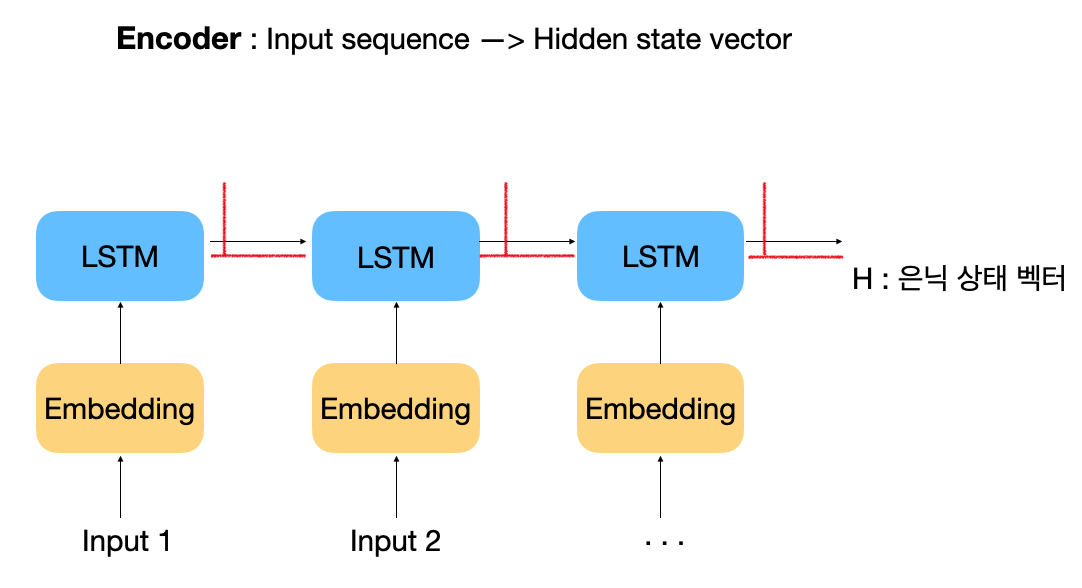

In [34]:
Image('e1.png',width=600)

In [129]:

# declare simple encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, 1, -1)
        x, hidden = self.gru(x, hidden)
        return x, hidden

# 3. Decodeing

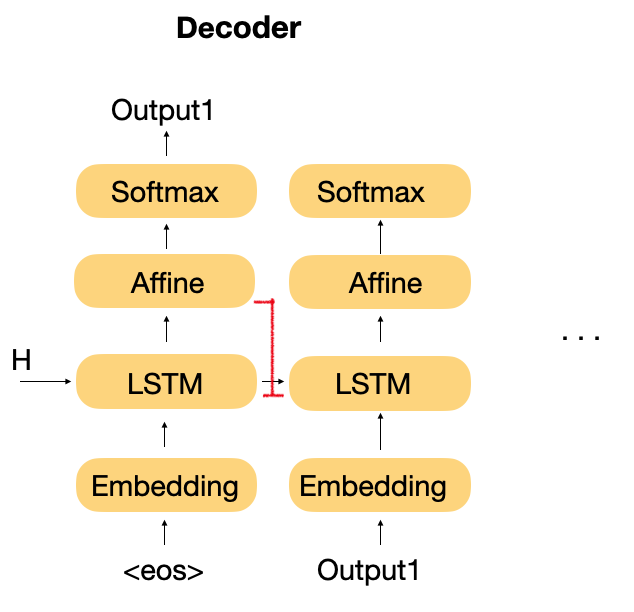

In [36]:
Image('d1.png',width=600)

In [130]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, 1, -1)
        x, hidden = self.gru(x, hidden)
        x = self.softmax(self.out(x[0]))
        return x, hidden

# 4. train data 가공  
  
sentence --> onehot vector --> pytorch tensor

In [120]:
def tensorize(vocab, sentence):
    indexes = [vocab.vocab2index[word] for word in sentence.split(" ")]
    indexes.append(vocab.vocab2index["<EOS>"])
    return torch.Tensor(indexes).long().to(device).view(-1, 1)

# 5. Training  
  
- Optimizer  
- Extract randomly elements in pairs list.  
- Tensorize the elements and then store them in training_source and target_source. 

In [131]:
# training seq2seq
def train(pairs, source_vocab, target_vocab, encoder, decoder, n_iter, print_every=1000, learning_rate=0.01):
    loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_batch = [random.choice(pairs) for _ in range(n_iter)]
    training_source = [tensorize(source_vocab, pair[0]) for pair in training_batch]
    training_target = [tensorize(target_vocab, pair[1]) for pair in training_batch]

    criterion = nn.NLLLoss()

    for i in range(1, n_iter + 1):
        source_tensor = training_source[i - 1]
        target_tensor = training_target[i - 1]

        encoder_hidden = torch.zeros([1, 1, encoder.hidden_size]).to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        source_length = source_tensor.size(0)
        target_length = target_tensor.size(0)

        loss = 0

        for enc_input in range(source_length):
            _, encoder_hidden = encoder(source_tensor[enc_input], encoder_hidden)

        decoder_input = torch.Tensor([[SOS_token]]).long().to(device)
        decoder_hidden = encoder_hidden # connect encoder output to decoder input

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # teacher forcing

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        loss_iter = loss.item() / target_length
        loss_total += loss_iter

        if i % print_every == 0:
            loss_avg = loss_total / print_every
            loss_total = 0
            print("[{} - {}%] loss = {:05.4f}".format(i, i / n_iter * 100, loss_avg))


# 6. Test

In [132]:
# insert given sentence to check the training
def evaluate(pairs, source_vocab, target_vocab, encoder, decoder, target_max_length):
    for pair in pairs:
        print(">", pair[0])
        print("=", pair[1])
        source_tensor = tensorize(source_vocab, pair[0])
        source_length = source_tensor.size()[0]
        encoder_hidden = torch.zeros([1, 1, encoder.hidden_size]).to(device)

        for ei in range(source_length):
            _, encoder_hidden = encoder(source_tensor[ei], encoder_hidden)

        decoder_input = torch.Tensor([[SOS_token]], device=device).long()
        decoder_hidden = encoder_hidden
        decoded_words = []

        for di in range(target_max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, top_index = decoder_output.data.topk(1)
            if top_index.item() == EOS_token:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(target_vocab.index2vocab[top_index.item()])

            decoder_input = top_index.squeeze().detach()

        predict_words = decoded_words
        predict_sentence = " ".join(predict_words)
        print("<", predict_sentence)
        print("")

# 7 Main

In [139]:
SOURCE_MAX_LENNGTH = 22
TARGET_MAX_LENGTH = 22
load_pairs, load_source_vocab, load_target_vocab = preprocess(raw, source_max_length, target_max_length)
print(random.choice(load_pairs))

reading corpus...
Read 4 sentence pairs
Trimmed to 4 sentence pairs
Counting words...
source vocab size = 21
target vocab size = 20
['i want to study computer science.', '나는 컴퓨터 과학을 공부하고 싶다.']


In [140]:
enc_hidden_size = 16
dec_hidden_size = 16
enc = Encoder(load_source_vocab.n_vocab, enc_hidden_size).to(device)
dec = Decoder(dec_hidden_size, load_target_vocab.n_vocab).to(device)

In [147]:
train(load_pairs, load_source_vocab, load_target_vocab, enc, dec, 10, print_every=1000)


In [148]:
evaluate(load_pairs, load_source_vocab, load_target_vocab, enc, dec, target_max_length)

> i want to study computer science.
= 나는 컴퓨터 과학을 공부하고 싶다.
< 나는 컴퓨터 과학을 공부하고 싶다. <EOS>

> the coding is interesting but quite difficult.
= 코딩은 재밌지만 다소 어렵다.
< 코딩은 재밌지만 다소 어렵다. <EOS>

> excellent coding skills is necessary to study computer science.
= 탁월한 코딩 능력은 컴퓨터 과학을 공부하는 데 필수적이다.
< 탁월한 코딩 능력은 컴퓨터 과학을 공부하는 데 필수적이다. <EOS>

> i will do better.
= 나는 더 잘할 것이다.
< 나는 더 잘할 것이다. <EOS>



# 참고:  
https://www.youtube.com/watch?v=lufb-1-XGMo&list=PLQ28Nx3M4JrhkqBVIXg-i5_CVVoS1UzAv&index=33